# CENG476 Introduction to Machine Learning
# Assignment II Part I
# 171180758
# Candan Baykan

In [1]:
# Import required modules.
from IPython.display import display
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Read the dataset and store it into a data frame with given column names.
df = pd.read_csv('car.data', header=None, names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'acceptability'])
df = df.drop('doors', axis=1)
df = df.drop('lug_boot', axis=1)

# Check whether the car is profitable or not.
y = ['no'] * df.shape[0]
for i, row in df.iterrows():
    if row['acceptability'] != 'unacc':
        y[i] = 'yes'

df = df.drop('acceptability', axis=1)
df['profitable'] = y
X = df.drop('profitable', axis=1)
display(df)

# Split dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=171180758)

,buying,maint,persons,safety,profitable
0,vhigh,vhigh,2,low,no
1,vhigh,vhigh,2,med,no
2,vhigh,vhigh,2,high,no
3,vhigh,vhigh,2,low,no
4,vhigh,vhigh,2,med,no
...,...,...,...,...,...
1723,low,low,more,med,yes
1724,low,low,more,high,yes
1725,low,low,more,low,no
1726,low,low,more,med,yes


## Part A
### Decision Tree Implementation

In [3]:
def entropy(positive, negative):
    if positive == 0 or negative == 0:
        return 0
    total = positive + negative
    p_positive = positive / total
    p_negative = negative / total
    return - p_positive * math.log2(p_positive) - p_negative * math.log2(p_negative)

def information_gain(data, feature, target):
    pos = data[data[target] == 'yes'].shape[0]
    neg = data[data[target] == 'no'].shape[0]
    gain = entropy(pos, neg)

    for value in data[feature].unique():
        df_value = data[data[feature] == value]
        pos = df_value[df_value[target] == 'yes'].shape[0]
        neg = df_value[df_value[target] == 'no'].shape[0]
        gain -= (df_value.shape[0] / data.shape[0]) * entropy(pos, neg)

    return gain

def gini(positive, negative):
    total = positive + negative
    return 1 - (positive / total) ** 2 - (negative / total) ** 2

def gini_index(data, feature, target):
    total = data.shape[0]
    gi = 0
    for value in data[feature].unique():
        filtered_data = data[data[feature] == value]
        length = filtered_data.shape[0]
        pos = filtered_data[filtered_data[target] == 'yes'].shape[0]
        neg = filtered_data[filtered_data[target] == 'no'].shape[0]
        gi += (length / total) * gini(pos, neg)

    return gi


class Node:

    def __init__(self):
        self.label = None
        self.siblings = dict()

def create_decision_tree(data, features, target, strategy='information_gain'):
    # Create a node to add to the tree.
    node = Node()
    # If all rows have same class, return the node with that class.
    if len(data[target].unique()) == 1:
        node.label = data[target].unique()[0]
        return node
    # If there is no feature left, then return the node with most common class.
    elif len(features) == 0:
        if data[data[target] == 'yes'].shape[0] > data[data[target] == 'no'].shape[0]:
            node.label = 'yes'
        else:
            node.label = 'no'
    else:
        # Choose the best feature to split tree using information gain or gini index.
        if strategy == 'information_gain':
            gains = dict()
            for feature in features:
                gains[feature] = information_gain(data, feature, target)

            best_feature = max(gains, key=gains.get)
        elif strategy == 'gini_index':
            ginis = dict()
            for feature in features:
                ginis[feature] = gini_index(data, feature, target)

            best_feature = min(ginis, key=ginis.get)

        # Remove the chosen feature from list.
        features.remove(best_feature)
        # Set label to the best feature's name.
        node.label = best_feature
        for value in data[best_feature].unique():
            # Filter the rows that meet the condition (best_feature == value).
            filtered_data = data[data[best_feature] == value]
            # If there are no rows that meet the condition, create a subnode with the most common value in unfiltered data.
            if filtered_data.shape[0] == 0:
                sub_node = Node()
                if data[data[target] == 'yes'].shape[0] > data[data[target] == 'no'].shape[0]:
                    sub_node.label = 'yes'
                else:
                    sub_node.label = 'no'

                node.siblings[value] = sub_node    
            else:
                node.siblings[value] = create_decision_tree(filtered_data, features.copy(), target, strategy)

    return node

def print_decision_tree(node, level=0):
    if not node.siblings:
        print(f' : {node.label}')
        return
    
    print()
    for sibling in node.siblings:
        if level != 0:
            print('\t' * (level - 1), '| ',  node.label, end='', sep='')
        else:
            print(node.label, end='')
        print(f' = {sibling}', end='')
        print_decision_tree(node.siblings[sibling], level + 1)

def predict(node, row):
    while node.siblings:
        node = node.siblings[row[node.label]]

    return node.label

def accuracy(predictions, y_test):
    true_cnt = 0
    for i in range(len(predictions)):
        if predictions[i] == y_test[i]:
            true_cnt += 1

    return true_cnt / len(y_test)

### Training Data

In [4]:
df_train = X_train.copy()
df_train['profitable'] = y_train.copy()
display(df_train)

,buying,maint,persons,safety,profitable
1111,med,med,2,med,no
584,high,high,4,high,yes
1185,med,med,more,low,no
501,high,vhigh,4,low,no
1460,low,high,2,high,no
...,...,...,...,...,...
1051,med,high,more,med,yes
1489,low,high,2,med,no
189,vhigh,high,2,low,no
1466,low,high,2,high,no


### Information Gain Decision Tree

In [5]:
ig_decision_tree = create_decision_tree(df_train, ['buying', 'maint', 'persons', 'safety'], 'profitable', 'information_gain')
print(f'Root Node\'s Information Gain: {information_gain(df_train, ig_decision_tree.label, "profitable")}')
print_decision_tree(ig_decision_tree)

Root Node's Information Gain: 0.23139045239171413

safety = med
| persons = 2 : no
| persons = 4
	| buying = high
		| maint = vhigh : no
		| maint = med : no
		| maint = low : yes
		| maint = high : yes
	| buying = vhigh
		| maint = high : no
		| maint = vhigh : no
		| maint = med : yes
		| maint = low : no
	| buying = med
		| maint = med : yes
		| maint = high : yes
		| maint = vhigh : yes
		| maint = low : yes
	| buying = low
		| maint = high : yes
		| maint = med : yes
		| maint = low : yes
		| maint = vhigh : no
| persons = more
	| buying = low
		| maint = low : yes
		| maint = vhigh : yes
		| maint = med : yes
		| maint = high : yes
	| buying = high
		| maint = high : yes
		| maint = low : yes
		| maint = med : no
		| maint = vhigh : no
	| buying = med
		| maint = high : yes
		| maint = vhigh : yes
		| maint = low : yes
		| maint = med : yes
	| buying = vhigh
		| maint = high : no
		| maint = med : yes
		| maint = low : yes
		| maint = vhigh : no
safety = high
| persons = 4
	| mai

### Gini Index Decision Tree

In [6]:
gi_decision_tree = create_decision_tree(df_train, ['buying', 'maint', 'persons', 'safety'], 'profitable', 'gini_index')
print(f'Root Node\'s Gini Index: {gini_index(df_train, gi_decision_tree.label, "profitable")}')
print_decision_tree(gi_decision_tree)

Root Node's Gini Index: 0.32264253932307974

safety = med
| persons = 2 : no
| persons = 4
	| buying = high
		| maint = vhigh : no
		| maint = med : no
		| maint = low : yes
		| maint = high : yes
	| buying = vhigh
		| maint = high : no
		| maint = vhigh : no
		| maint = med : yes
		| maint = low : no
	| buying = med
		| maint = med : yes
		| maint = high : yes
		| maint = vhigh : yes
		| maint = low : yes
	| buying = low
		| maint = high : yes
		| maint = med : yes
		| maint = low : yes
		| maint = vhigh : no
| persons = more
	| buying = low
		| maint = low : yes
		| maint = vhigh : yes
		| maint = med : yes
		| maint = high : yes
	| buying = high
		| maint = high : yes
		| maint = low : yes
		| maint = med : no
		| maint = vhigh : no
	| buying = med
		| maint = high : yes
		| maint = vhigh : yes
		| maint = low : yes
		| maint = med : yes
	| buying = vhigh
		| maint = high : no
		| maint = med : yes
		| maint = low : yes
		| maint = vhigh : no
safety = high
| persons = 4
	| maint = h

### Accuracy

In [7]:
ig_predictions = list()
gi_predictions = list()
for _, row in X_test.iterrows():
    ig_predictions.append(predict(ig_decision_tree, row))
    gi_predictions.append(predict(gi_decision_tree, row))

print(f'Information Gain Accuracy: {accuracy(ig_predictions, y_test):.2f}')
print(f'Gini Index Accuracy: {accuracy(gi_predictions, y_test):.2f}')

Information Gain Accuracy: 0.91
Gini Index Accuracy: 0.91


## Part B
### Data Conversions for scikit-learn

In [8]:
sk_X_train = X_train.copy()
sk_X_test = X_test.copy()

sk_X_train['buying'] = X_train['buying'].map({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}).astype('category')
sk_X_test['buying'] = X_test['buying'].map({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}).astype('category')

sk_X_train['maint'] = X_train['maint'].map({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}).astype('category')
sk_X_test['maint'] = X_test['maint'].map({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}).astype('category')

sk_X_train['persons'] = X_train['persons'].map({'2': 2, '4': 4, 'more': 5}).astype('category')
sk_X_test['persons'] = X_test['persons'].map({'2': 2, '4': 4, 'more': 5}).astype('category')

sk_X_train['safety'] = X_train['safety'].map({'low': 0, 'med': 1, 'high': 2}).astype('category')
sk_X_test['safety'] = X_test['safety'].map({'low': 0, 'med': 1, 'high': 2}).astype('category')

display(sk_X_train)
display(sk_X_test)

,buying,maint,persons,safety
1111,1,1,2,1
584,2,2,4,2
1185,1,1,5,0
501,2,3,4,0
1460,0,2,2,2
...,...,...,...,...
1051,1,2,5,1
1489,0,2,2,1
189,3,2,2,0
1466,0,2,2,2


,buying,maint,persons,safety
1123,1,1,4,1
1669,0,0,5,1
463,2,3,2,1
975,1,2,2,0
347,3,0,5,2
...,...,...,...,...
1398,0,3,5,0
897,1,3,2,0
193,3,2,2,1
535,2,3,5,1


### scikit-learn's Accuracy

In [9]:
ig_dtc = DecisionTreeClassifier(criterion='entropy')
ig_dtc = ig_dtc.fit(sk_X_train, y_train)
sk_ig_predictions = ig_dtc.predict(sk_X_test)
print(f'scikit-learn Information Gain Accuracy: {accuracy(sk_ig_predictions, y_test):.2f}')

gi_dtc = DecisionTreeClassifier(criterion='gini')
gi_dtc = gi_dtc.fit(sk_X_train, y_train)
sk_gi_predictions = gi_dtc.predict(sk_X_test)
print(f'scikit-learn Information Gain Accuracy: {accuracy(sk_gi_predictions, y_test):.2f}')

scikit-learn Information Gain Accuracy: 0.91
scikit-learn Information Gain Accuracy: 0.91


### scikit-learn's Information Gain Decision Tree

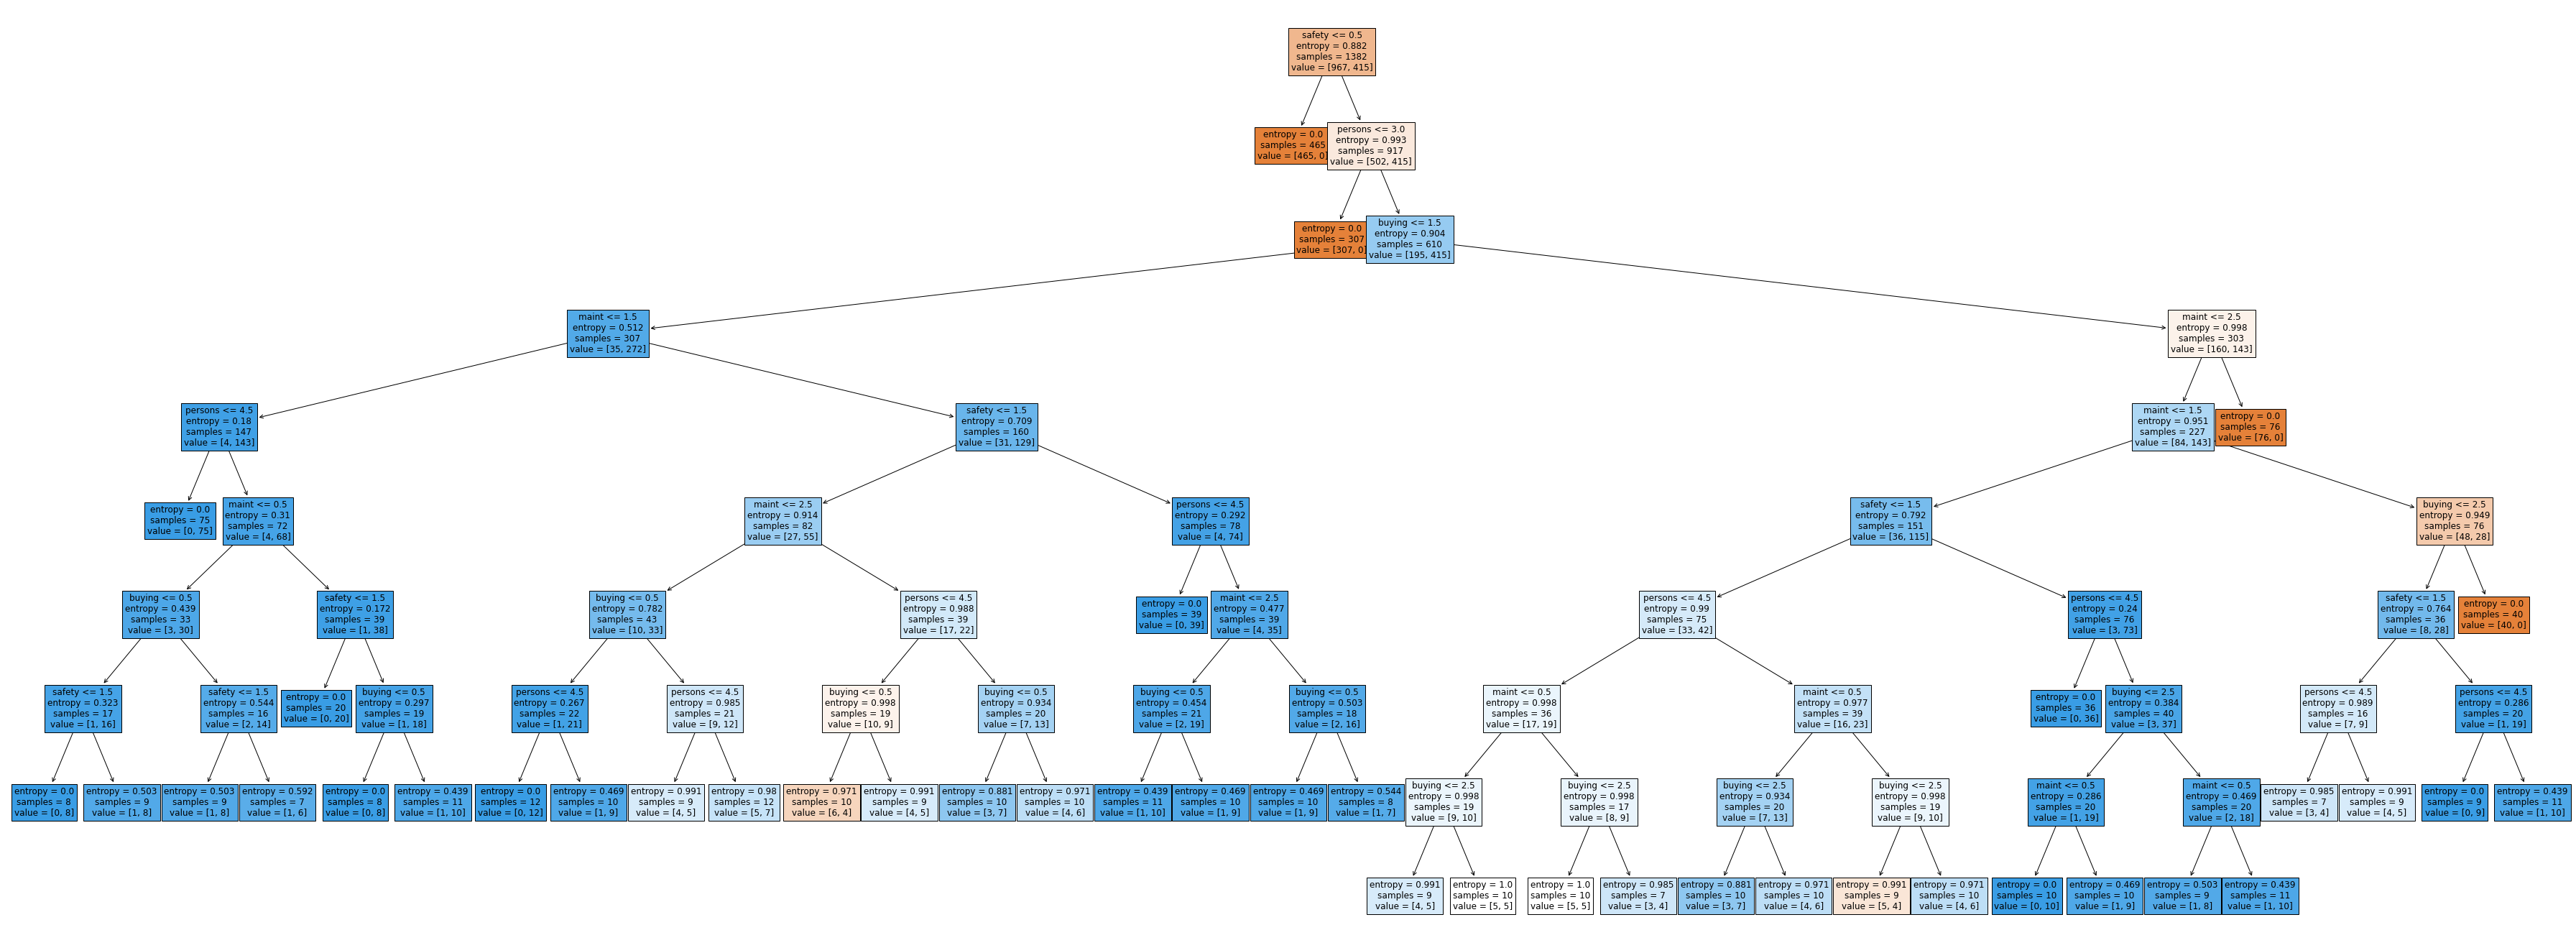

In [10]:
plt.figure(figsize=(64, 24))
tree.plot_tree(ig_dtc, fontsize=12, feature_names=sk_X_train.columns, filled=True)
plt.show()

### scikit-learn's Gini Index Decision Tree

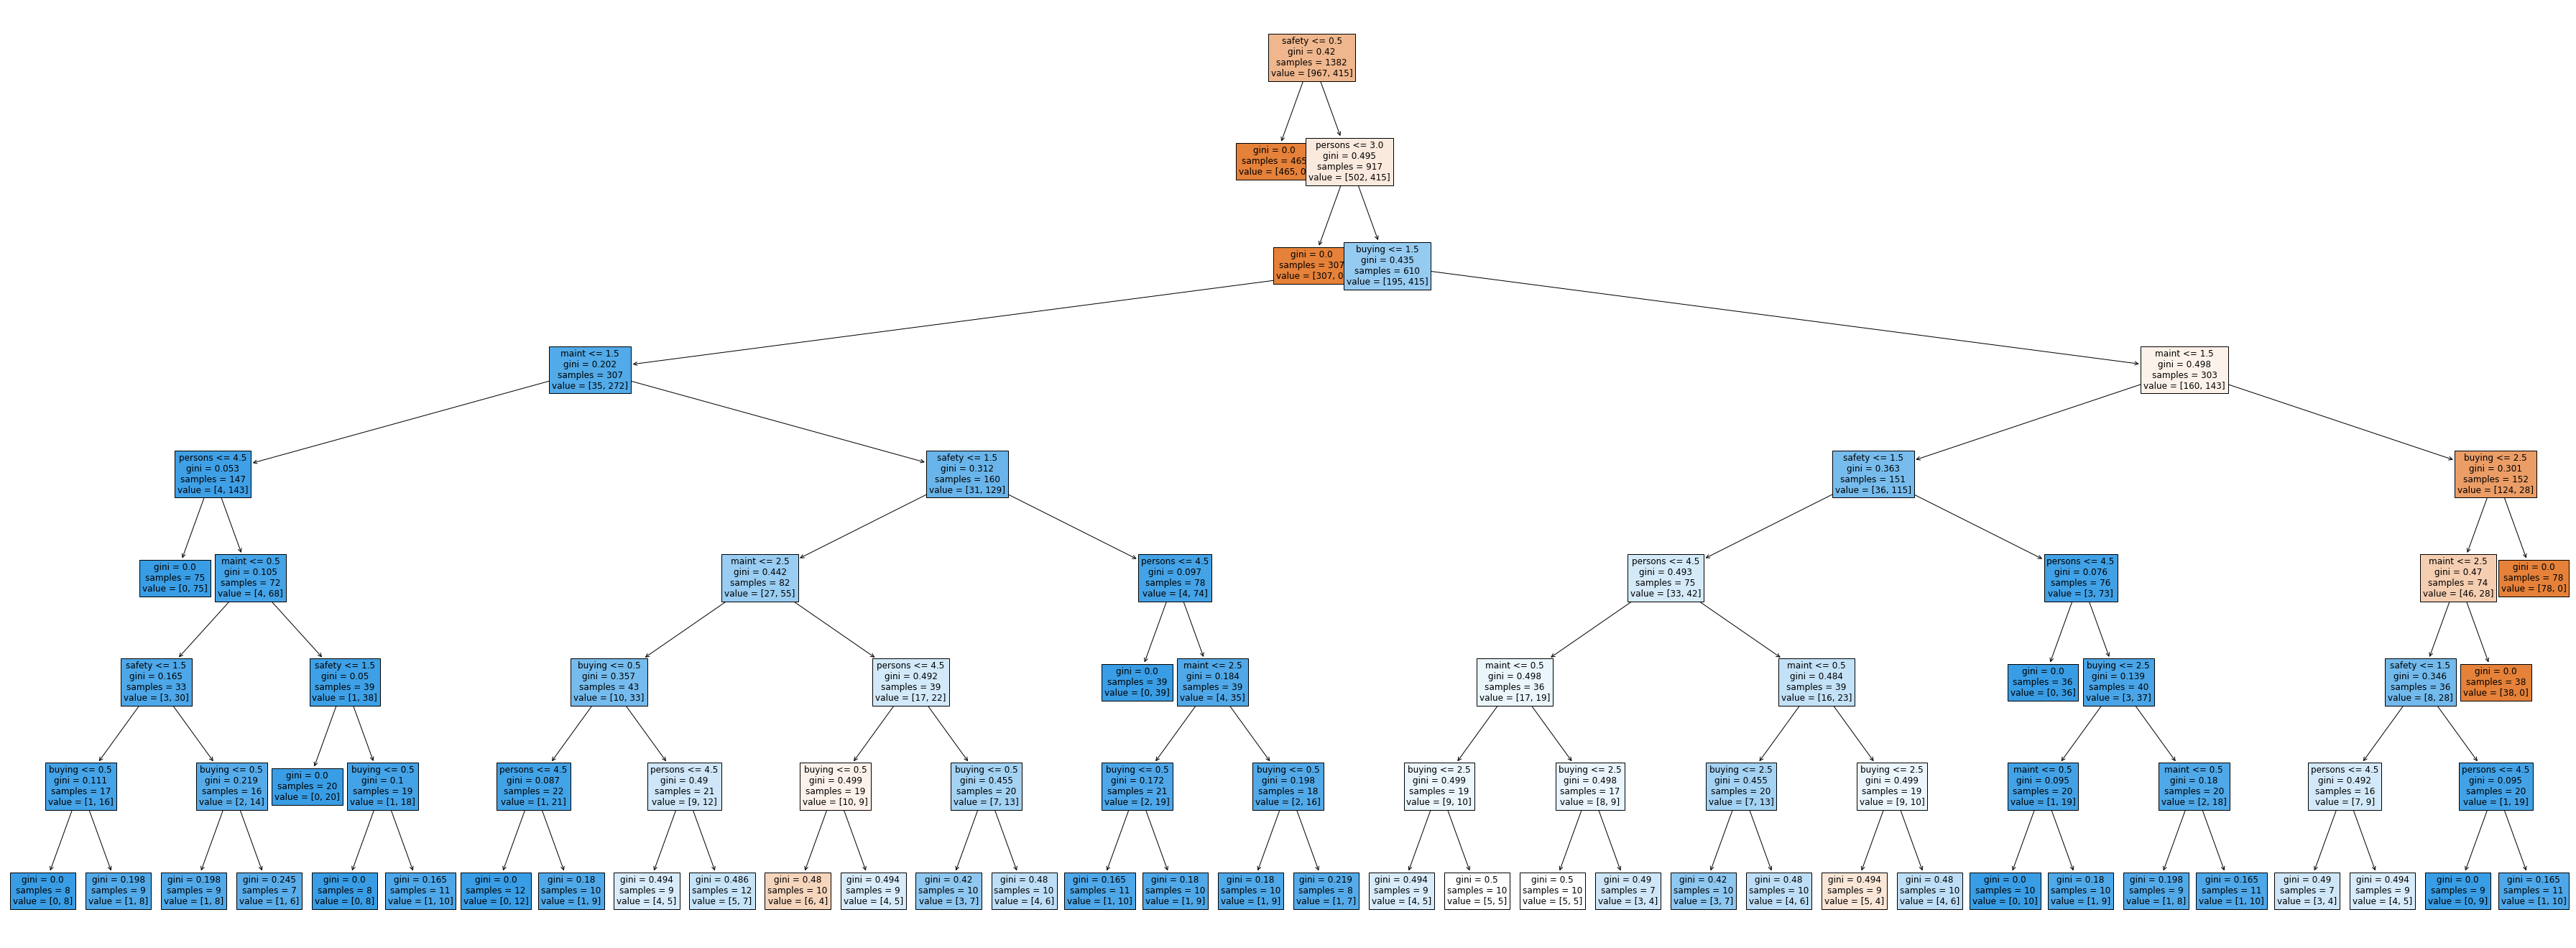

In [11]:
plt.figure(figsize=(64, 24))
tree.plot_tree(gi_dtc, fontsize=12, feature_names=sk_X_train.columns, filled=True)
plt.show()

## My Implementation and scikit-learn Prediction Differences and False Predictions

In [12]:
diff_df = pd.DataFrame(columns=['y_test', 'my_ig', 'my_gi', 'sk_ig', 'sk_gi'])
for i in range(len(y_test)):
    if y_test[i] != ig_predictions[i] or ig_predictions[i] != gi_predictions[i] or gi_predictions[i] != sk_ig_predictions[i] or sk_ig_predictions[i] != sk_gi_predictions[i]:
        diff_df.loc[i, 'y_test'] = y_test[i]
        diff_df.loc[i, 'my_ig'] = ig_predictions[i]
        diff_df.loc[i, 'my_gi'] = gi_predictions[i]
        diff_df.loc[i, 'sk_ig'] = sk_ig_predictions[i]
        diff_df.loc[i, 'sk_gi'] = sk_gi_predictions[i]

display(diff_df)


,y_test,my_ig,my_gi,sk_ig,sk_gi
6,no,yes,yes,yes,yes
8,no,yes,yes,yes,yes
23,no,yes,yes,yes,yes
34,no,yes,yes,yes,yes
53,no,yes,yes,yes,yes
54,no,yes,yes,yes,yes
58,no,yes,yes,yes,yes
91,no,yes,yes,yes,yes
105,yes,no,no,no,no
106,no,yes,yes,yes,yes
